In [1]:
import numpy as np
import cv2
import re
import pandas as pd
import os
import platform
import tensorflow as tf 
from numpy.random import seed
from glob import glob
from os.path import basename, join, exists
from collections import Counter
from json import load, dump
from sklearn import metrics
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,BatchNormalization,Activation,AveragePooling2D,Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.utils import Sequence
from tensorflow.keras.optimizers import SGD, Adam
# from tensorflow import set_random_seed
from IPython.display import display, Markdown
from statistics import mean
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

In [2]:
# Test if the jupyternotebook is running on the GPU
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


### 1. Read images

In [3]:
# define a function to read all the images and add labels
# image size = 40 X 40
import glob
# function to read images and convert each image to a [40,40,1] format
def Read_Image_40(imageDirectory):
    imageFormat = ['png']    # Add image formats here
    files = []
    [files.extend(glob.glob(imageDirectory + '*.' + e)) for e in imageFormat]
    imagesList = np.empty(len(files), dtype=object)
    for n in range(0, len(files)):
        image = cv2.imread(files[n],-1)
        image.reshape((40, 40, 1))
        imagesList[n] = np.array(image)
    return imagesList  

#### 1.1 Read intensity, tm images

In [4]:
# read intensity images
controlIntImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/NADH Intensity/Control/'
glyIntImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/NADH Intensity/Glycolysis/'
cyanideIntImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/NADH Intensity/OXPHOS/'

controlIntImageList = Read_Image_40(controlIntImageDirectory)
glyIntImageList = Read_Image_40(glyIntImageDirectory)
cyanideIntImageList = Read_Image_40(cyanideIntImageDirectory)


# read tm images
controlTmImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/tm/Control/'
glyTmImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/tm/Glycolysis/'
cyanideTmImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/tm/OXPHOS/'

controlTmImageList = Read_Image_40(controlTmImageDirectory)
glyTmImageList = Read_Image_40(glyTmImageDirectory)
cyanideTmImageList = Read_Image_40(cyanideTmImageDirectory)



#### 1.2 Read t1, t2, a1 images

In [5]:
# read t1 images
controlT1ImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/t1/Control/'
glyT1ImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/t1/Glycolysis/'
cyanideT1ImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/t1/OXPHOS/'

controlT1ImageList = Read_Image_40(controlT1ImageDirectory)
glyT1ImageList = Read_Image_40(glyT1ImageDirectory)
cyanideT1ImageList = Read_Image_40(cyanideT1ImageDirectory)

# read t2 images
controlT2ImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/t2/Control/'
glyT2ImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/t2/Glycolysis/'
cyanideT2ImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/t2/OXPHOS/'

controlT2ImageList = Read_Image_40(controlT2ImageDirectory)
glyT2ImageList = Read_Image_40(glyT2ImageDirectory)
cyanideT2ImageList = Read_Image_40(cyanideT2ImageDirectory)

# read a1 images
controlA1ImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/a1/Control/'
glyA1ImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/a1/Glycolysis/'
cyanideA1ImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/a1/OXPHOS/'

controlA1ImageList = Read_Image_40(controlA1ImageDirectory)
glyA1ImageList = Read_Image_40(glyA1ImageDirectory)
cyanideA1ImageList = Read_Image_40(cyanideA1ImageDirectory)

#### 1.3 Read FAD intensity images

In [6]:
# read FAD intensity images
controlFADImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/FAD Intensity/Control/'
glyFADImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/FAD Intensity/Glycolysis/'
cyanideFADImageDirectory = 'C:/Users/hulinghao/Documents/Python/CNN_Classification_Cell/Dataset/40 x 40/FAD Intensity/OXPHOS/'

#### 1.3 Combine the intensiy, tm, t1, t2, a1 images, and add labels

In [7]:
def Combine_All_Endpoints(intImageList, tmImageList, t1ImageList, t2ImageList, a1ImageList, label):
    imageList = np.empty(len(intImageList), dtype=object)
    for i in range(len(intImageList)):
            intImage = intImageList[i]
            tmImage = tmImageList[i]
            t1Image = t1ImageList[i]
            t2Image = t2ImageList[i]
            a1Image = a1ImageList[i] 
            image = np.array([intImage,tmImage,t1Image,t2Image,a1Image])
            imageList[i] = [np.transpose(image,(1,2,0)),label]
    return imageList    

In [8]:
controlImageList = Combine_All_Endpoints(controlIntImageList,controlTmImageList,controlT1ImageList,controlT2ImageList,controlA1ImageList,2)
glyImageList = Combine_All_Endpoints(glyIntImageList,glyTmImageList,glyT1ImageList,glyT2ImageList,glyA1ImageList,0)
cyanideImageList = Combine_All_Endpoints(cyanideIntImageList,cyanideTmImageList,cyanideT1ImageList,cyanideT2ImageList,cyanideA1ImageList,1)

#### 1.3 Check a typical image

In [9]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

#### Control

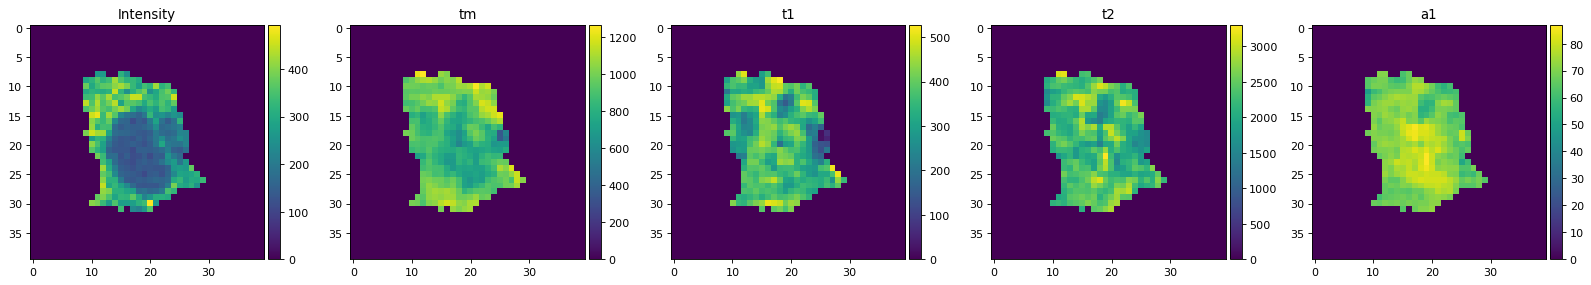

In [10]:
n = 1000
fig, (ax1, ax2, ax3, ax4, ax5 ) = plt.subplots(ncols=5,figsize=(20, 20), dpi=80)
img1 = ax1.imshow(controlImageList[n][0][:,:,0])
colorbar(img1)
img2 = ax2.imshow(controlImageList[n][0][:,:,1])
colorbar(img2)
img3 = ax3.imshow(controlImageList[n][0][:,:,2])
colorbar(img3)
img4 = ax4.imshow(controlImageList[n][0][:,:,3])
colorbar(img4)
img5 = ax5.imshow(controlImageList[n][0][:,:,4])
colorbar(img5)
ax1.title.set_text('Intensity')
ax2.title.set_text('tm')
ax3.title.set_text('t1')
ax4.title.set_text('t2')
ax5.title.set_text('a1')
plt.tight_layout(h_pad=1)

#### Glycolysis Inhibition

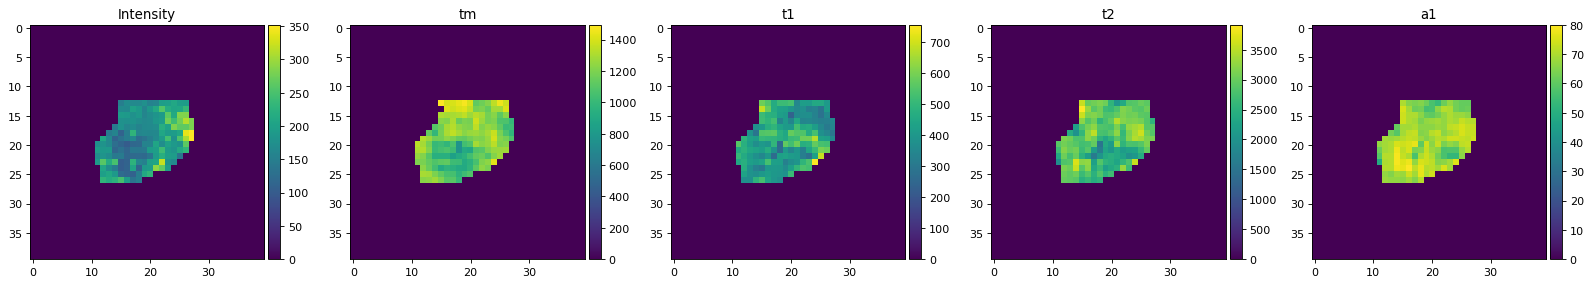

In [11]:
n = 1000
fig, (ax1, ax2, ax3, ax4, ax5 ) = plt.subplots(ncols=5,figsize=(20, 20), dpi=80)
img1 = ax1.imshow(glyImageList[n][0][:,:,0])
colorbar(img1)
img2 = ax2.imshow(glyImageList[n][0][:,:,1])
colorbar(img2)
img3 = ax3.imshow(glyImageList[n][0][:,:,2])
colorbar(img3)
img4 = ax4.imshow(glyImageList[n][0][:,:,3])
colorbar(img4)
img5 = ax5.imshow(glyImageList[n][0][:,:,4])
colorbar(img5)
ax1.title.set_text('Intensity')
ax2.title.set_text('tm')
ax3.title.set_text('t1')
ax4.title.set_text('t2')
ax5.title.set_text('a1')
plt.tight_layout(h_pad=1)

#### OXPHOS Inhibition

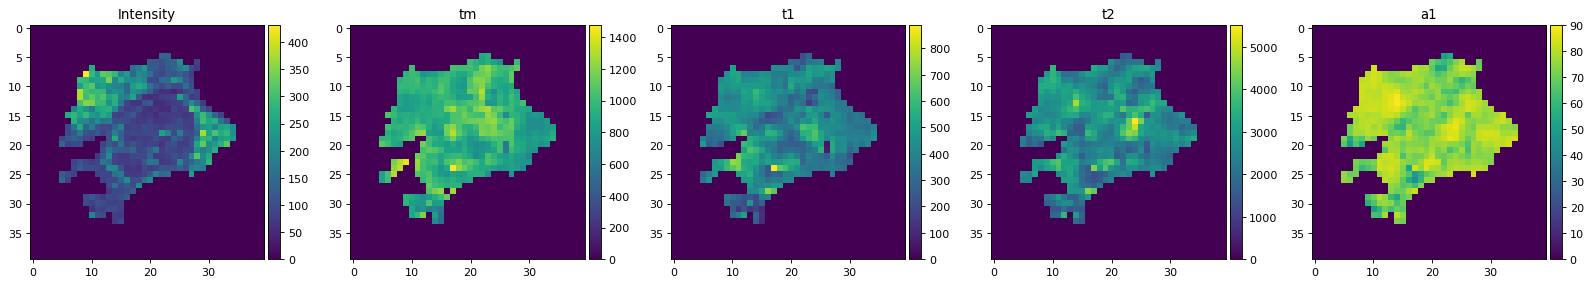

In [12]:
n = 1000
fig, (ax1, ax2, ax3, ax4, ax5 ) = plt.subplots(ncols=5,figsize=(20, 20), dpi=80)
img1 = ax1.imshow(cyanideImageList[n][0][:,:,0])
colorbar(img1)
img2 = ax2.imshow(cyanideImageList[n][0][:,:,1])
colorbar(img2)
img3 = ax3.imshow(cyanideImageList[n][0][:,:,2])
colorbar(img3)
img4 = ax4.imshow(cyanideImageList[n][0][:,:,3])
colorbar(img4)
img5 = ax5.imshow(cyanideImageList[n][0][:,:,4])
colorbar(img5)
ax1.title.set_text('Intensity')
ax2.title.set_text('tm')
ax3.title.set_text('t1')
ax4.title.set_text('t2')
ax5.title.set_text('a1')
plt.tight_layout(h_pad=1)

### 2. Group the images

In [13]:
#### 2.1 Combine the dataset
# import math
# import random
# allDataset = np.concatenate((glyImageList,cyanideImageList), axis=0)

# random.shuffle(allDataset)
# # 75% dataset for training
# trainDataset = allDataset[:math.floor(len(allDataset)*0.75)]
# # 25% dataset for testing
# testDataset = allDataset[math.floor(len(allDataset)*0.75):]

#### 2.1 Get the label and image(normalize)

In [12]:
import math
import random
# Here we define a function to get the maximum for each endpoints
def Get_Maximum(Dataset):
    maxIntensityList = []
    maxTmList = []
    maxT1List = []
    maxT2List = []
    maxA1List = []
    for image in Dataset:
        # Intensity
        maxIntensity =  np.amax(image[0][:,:,0])
        maxIntensityList.append(maxIntensity)
        # tm
        maxTm =  np.amax(image[0][:,:,1])
        maxTmList.append(maxTm)
        # t1
        maxT1 =  np.amax(image[0][:,:,2])
        maxT1List.append(maxT1)
        # t2
        maxT2 =  np.amax(image[0][:,:,3])
        maxT2List.append(maxT2)
        # a1
        maxA1 =  np.amax(image[0][:,:,4])
        maxA1List.append(maxA1) 
        
        maxValues = np.array ([max(maxIntensityList),max(maxTmList),max(maxT1List),max(maxT2List),max(maxA1List)])
    return(maxValues)

In [13]:
# allDataset = np.concatenate((glyImageList,cyanideImageList,controlImageList), axis=0)
allDataset = np.concatenate((glyImageList,cyanideImageList), axis=0)
maxValues = Get_Maximum(allDataset)

In [14]:
# Image size is 40 X 40
def Get_Label_Image(dataset,maxValues):
    label = np.empty(len(dataset), dtype=object)
# image size(40,40)
    image = np.empty(shape = (len(dataset),40,40,5))

    for i in range(len(dataset)):
        label[i] = np.array(dataset[i][1])
        image[i][:,:,0] = dataset[i][0][:,:,0]/maxValues[0]
        image[i][:,:,1] = dataset[i][0][:,:,1]/maxValues[1]
        image[i][:,:,2] = dataset[i][0][:,:,2]/maxValues[2]
        image[i][:,:,3] = dataset[i][0][:,:,3]/maxValues[3]
        image[i][:,:,4] = dataset[i][0][:,:,4]/100
    return(image, label)

In [17]:
# (trainImage, trainLabel) = Get_Label_Image(trainDataset,maxValues)
# (testImage, testLabel) = Get_Label_Image(testDataset,maxValues)

#### 2.2 Get training and testing dataset

In [15]:
from sklearn.model_selection import train_test_split
(allImage,allLabel) = Get_Label_Image(allDataset,maxValues)
trainImage,testValidImage,trainLabel,testValidLabel = train_test_split(allImage, allLabel, test_size= 0.4, random_state=1, stratify=allLabel)
testImage,validImage,testLabel,validLabel = train_test_split(testValidImage, testValidLabel, test_size= 0.25, random_state=1, stratify=testValidLabel)

In [16]:
print(allImage.shape)

print(trainImage.shape)
print(validImage.shape)
print(testImage.shape)

print(trainLabel.shape)
print(validLabel.shape)
print(testLabel.shape)

(5067, 40, 40, 5)
(3040, 40, 40, 5)
(507, 40, 40, 5)
(1520, 40, 40, 5)
(3040,)
(507,)
(1520,)


#### 2.3 Check with one image

(-0.5, 39.5, 39.5, -0.5)

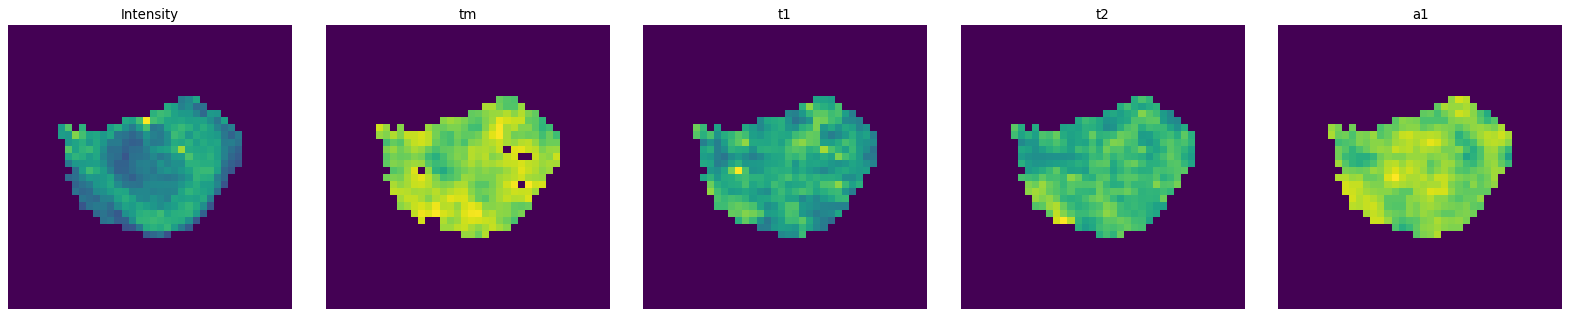

In [19]:
n = 0
fig, (ax1, ax2, ax3, ax4, ax5 ) = plt.subplots(ncols=5,figsize=(20, 20), dpi=80)
img1 = ax1.imshow(trainImage[n][:,:,0])
# colorbar(img1)
img2 = ax2.imshow(trainImage[n][:,:,1])
# colorbar(img2)
img3 = ax3.imshow(trainImage[n][:,:,2])
# colorbar(img3)
img4 = ax4.imshow(trainImage[n][:,:,3])
# colorbar(img4)
img5 = ax5.imshow(trainImage[n][:,:,4])
# colorbar(img5)
ax1.title.set_text('Intensity')
ax2.title.set_text('tm')
ax3.title.set_text('t1')
ax4.title.set_text('t2')
ax5.title.set_text('a1')
plt.tight_layout(h_pad=1)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')

#### 2.4 label to categorical

In [21]:
# Summary the data size, and default balanced class weights in the training
from tensorflow.keras.utils import to_categorical

glyCount = 0
OXPHOSCount = 0

for label in trainLabel:
    if label == 1:
        glyCount = glyCount + 1
    else:
        OXPHOSCount = OXPHOSCount + 1

balanceWeightClass = (len(trainLabel)/(2*OXPHOSCount))/(len(trainLabel)/(2*glyCount))

# Reshape the images for the model and encode the labels
# Generate a variable trainLabel to be convenient for future training and testing
trainLabelM = to_categorical(trainLabel,2)
testLabelM = to_categorical(testLabel,2)
validLabelM = to_categorical(validLabel,2)
# Image size 56 X 56 
# trainImage = trainImage.reshape((trainImage.shape[0], 56, 56, 2))
# testImage = testImage.reshape((testImage.shape[0], 56, 56, 2))

print('train Image: {}, train Label: {}'.format(trainImage.shape, trainLabelM.shape))
print('test Image: {}, test Label: {}'.format(testImage.shape, testLabelM.shape))
print('valid Image: {}, valid Label: {}'.format(validImage.shape, validLabelM.shape))
print('Balanced Class Weight: {}'.format(balanceWeightClass))

train Image: (3040, 40, 40, 5), train Label: (3040, 2)
test Image: (1520, 40, 40, 5), test Label: (1520, 2)
valid Image: (507, 40, 40, 5), valid Label: (507, 2)
Balanced Class Weight: 0.6973757677275265


#### 2.5 Enlarge the training dataset

In [22]:
# Enlarge the training dataset by rotate 45, 135, 90, 180, 270 degrees, and flip x y 

from scipy.ndimage.interpolation import rotate
import random
from scipy import ndimage

def Enlarge_Training(imageList):
    image45List = np.empty([len(imageList),40,40,5])
    image135List = np.empty([len(imageList),40,40,5])
    
    image90List = np.empty([len(imageList),40,40,5])
    image180List = np.empty([len(imageList),40,40,5])
    image270List = np.empty([len(imageList),40,40,5])    
    imageXflipList = np.empty([len(imageList),40,40,5])
    imageYflipList = np.empty([len(imageList),40,40,5])
    for i in range(len(imageList)):
        image45List[i] = ndimage.rotate(imageList[i], 45, reshape=False)
        image135List[i] = ndimage.rotate(imageList[i], 135, reshape=False)
        
        image90List[i] = np.rot90(imageList[i],k = 1)
        image180List[i] = np.rot90(imageList[i],k = 2)
        image270List[i] = np.rot90(imageList[i],k = 3)
        imageXflipList[i] = np.flip(imageList[i],0)
        imageYflipList[i] = np.flip(imageList[i],1)
    return(image45List,image135List,image90List,image180List,image270List,imageXflipList,imageYflipList)

In [23]:
(image45, image135, image90,image180,image270,imageXflip,imageYflip) = Enlarge_Training(trainImage)

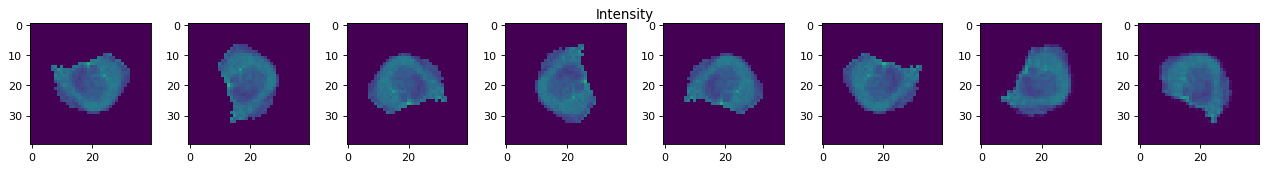

In [24]:
# Show intensity images： 

# select image
n = 0

fig, ax = plt.subplots(1, 8,figsize=(20,2), dpi=80)

ax[0].imshow(trainImage[n, :, :, 0], vmin=0, vmax=1)
ax[1].imshow(image90[n, :, :, 0], vmin=0, vmax=1)
ax[2].imshow(image180[n, :, :, 0], vmin=0, vmax=1)
ax[3].imshow(image270[n, :, :, 0], vmin=0, vmax=1)
ax[4].imshow(imageXflip[n, :, :, 0], vmin=0, vmax=1)
ax[5].imshow(imageYflip[n, :, :, 0], vmin=0, vmax=1)
ax[6].imshow(image45[n, :, :, 0], vmin=0, vmax=1)
ax[7].imshow(image135[n, :, :, 0], vmin=0, vmax=1)
fig.suptitle('Intensity', fontsize=12)
# fig.colorbar(a)
plt.show()

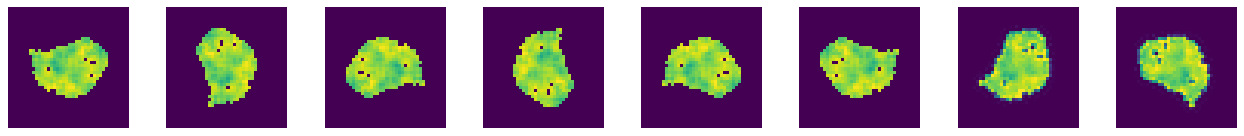

In [33]:
# Show lifetime images： 

# select image

fig, ax = plt.subplots(1, 8,figsize=(20,2), dpi=80)

ax[0].imshow(trainImage[n, :, :, 1], vmin=0, vmax=1)
ax[1].imshow(image90[n, :, :, 1], vmin=0, vmax=1)
ax[2].imshow(image180[n, :, :, 1], vmin=0, vmax=1)
ax[3].imshow(image270[n, :, :, 1], vmin=0, vmax=1)
ax[4].imshow(imageXflip[n, :, :, 1], vmin=0, vmax=1)
ax[5].imshow(imageYflip[n, :, :, 1], vmin=0, vmax=1)
ax[6].imshow(image45[n, :, :, 1], vmin=0, vmax=1)
ax[7].imshow(image135[n, :, :, 1], vmin=0, vmax=1)
# fig.suptitle('tm', fontsize=12)
# fig.colorbar(a)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
ax[4].axis('off')
ax[5].axis('off')
ax[6].axis('off')
ax[7].axis('off')


plt.show()

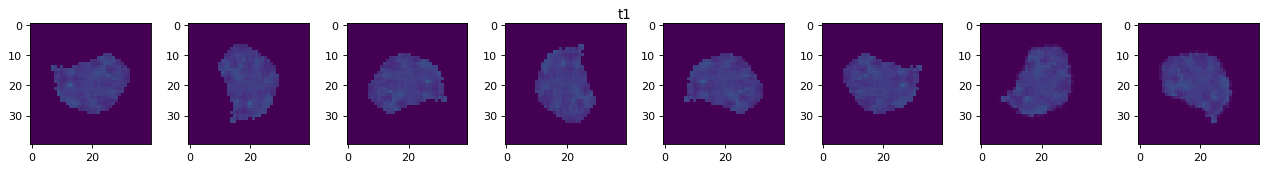

In [24]:
fig, ax = plt.subplots(1, 8,figsize=(20,2), dpi=80)

ax[0].imshow(trainImage[n, :, :, 2], vmin=0, vmax=1)
ax[1].imshow(image90[n, :, :, 2], vmin=0, vmax=1)
ax[2].imshow(image180[n, :, :, 2], vmin=0, vmax=1)
ax[3].imshow(image270[n, :, :, 2], vmin=0, vmax=1)
ax[4].imshow(imageXflip[n, :, :, 2], vmin=0, vmax=1)
ax[5].imshow(imageYflip[n, :, :, 2], vmin=0, vmax=1)
ax[6].imshow(image45[n, :, :, 2], vmin=0, vmax=1)
ax[7].imshow(image135[n, :, :, 2], vmin=0, vmax=1)
fig.suptitle('t1', fontsize=12)
# fig.colorbar(a)
plt.show()

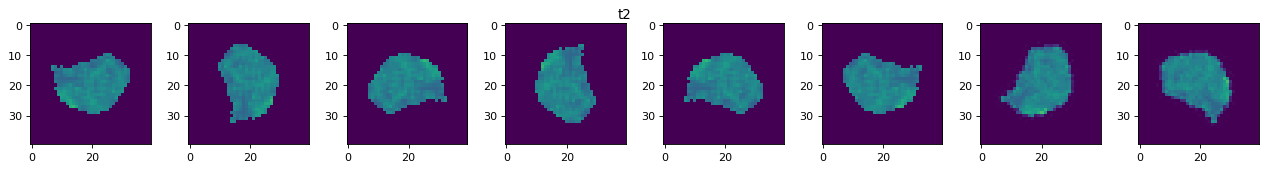

In [25]:
fig, ax = plt.subplots(1, 8,figsize=(20,2), dpi=80)

ax[0].imshow(trainImage[n, :, :, 3], vmin=0, vmax=1)
ax[1].imshow(image90[n, :, :, 3], vmin=0, vmax=1)
ax[2].imshow(image180[n, :, :, 3], vmin=0, vmax=1)
ax[3].imshow(image270[n, :, :, 3], vmin=0, vmax=1)
ax[4].imshow(imageXflip[n, :, :, 3], vmin=0, vmax=1)
ax[5].imshow(imageYflip[n, :, :, 3], vmin=0, vmax=1)
ax[6].imshow(image45[n, :, :, 3], vmin=0, vmax=1)
ax[7].imshow(image135[n, :, :, 3], vmin=0, vmax=1)
fig.suptitle('t2', fontsize=12)
# fig.colorbar(a)
plt.show()

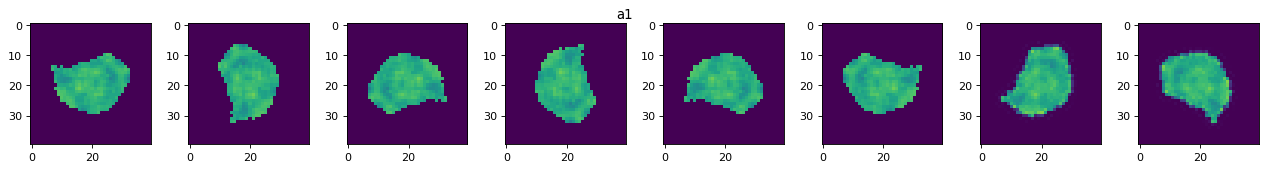

In [26]:
fig, ax = plt.subplots(1, 8,figsize=(20,2), dpi=80)

ax[0].imshow(trainImage[n, :, :, 4], vmin=0, vmax=1)
ax[1].imshow(image90[n, :, :, 4], vmin=0, vmax=1)
ax[2].imshow(image180[n, :, :, 4], vmin=0, vmax=1)
ax[3].imshow(image270[n, :, :, 4], vmin=0, vmax=1)
ax[4].imshow(imageXflip[n, :, :, 4], vmin=0, vmax=1)
ax[5].imshow(imageYflip[n, :, :, 4], vmin=0, vmax=1)
ax[6].imshow(image45[n, :, :, 4], vmin=0, vmax=1)
ax[7].imshow(image135[n, :, :, 4], vmin=0, vmax=1)
fig.suptitle('a1', fontsize=12)
# fig.colorbar(a)
plt.show()

In [16]:
enlargeTrainImage = np.concatenate((trainImage,image90,image180,image270,imageXflip,imageYflip,image45,image135),axis = 0)
enlargeTrainLabel = np.concatenate((trainLabelM,trainLabelM,trainLabelM,trainLabelM,trainLabelM,trainLabelM,trainLabelM,trainLabelM),axis = 0)

In [17]:
print(len(enlargeTrainImage))

print(len(enlargeTrainLabel))
# enlargeTrainLabel.shape
enlargeTrainImage.shape
enlargeTrainLabel.shape

24320
24320


(24320, 2)

### 3. Develop CNN

#### 3.1 Develop the CNN Model

In [30]:
def Develop_Model():
    model = Sequential()
    model.add(Conv2D(filters = 64, 
                     kernel_size = (3, 3), 
                     padding="valid",
                     activation='sigmoid', 
                     input_shape=(40, 40, 5)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides = 3))
    model.add(BatchNormalization())
    
    
    model.add(Conv2D(filters = 64,
                     kernel_size=(3,3),
                     padding="valid",
                     activation="sigmoid"))    
    model.add(MaxPooling2D(pool_size = 3, strides = 3))
    model.add(BatchNormalization())

#    map to 1x1 (flatten layer)
    model.add(Flatten())
    
    model.add(Dense(120, activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(80, activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation="softmax", name="Output"))

    
    # compile model
    opt = SGD(lr=0.00001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [32]:
from sklearn.model_selection import KFold
from sklearn.utils import class_weight
# fit model

history = lenet.fit(trainImage, trainLabelM, epochs = 10, batch_size = 32,validation_data=(validImage, validLabelM), verbose=0)
# evaluate model
_, acc = lenet.evaluate(testImage, testLabelM, verbose=0)
print('= %.3f' % (acc * 100.0))

= 62.763


In [31]:
lenet = Develop_Model()
lenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 38, 64)        2944      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience = 50)
history = lenet.fit(enlargeTrainImage, enlargeTrainLabel, epochs = 100, batch_size = 16,validation_data=(validImage, validLabelM), verbose = 1,callbacks=[es])

Epoch 1/100
1520/1520 [==============================] - 7s 4ms/step - loss: 0.6552 - accuracy: 0.6424 - val_loss: 0.5968 - val_accuracy: 0.6923
Epoch 2/100
1520/1520 [==============================] - 7s 4ms/step - loss: 0.5987 - accuracy: 0.7066 - val_loss: 0.5408 - val_accuracy: 0.7653
Epoch 3/100
1520/1520 [==============================] - 7s 4ms/step - loss: 0.5465 - accuracy: 0.7544 - val_loss: 0.4906 - val_accuracy: 0.8126
Epoch 4/100
1520/1520 [==============================] - 7s 4ms/step - loss: 0.5023 - accuracy: 0.7884 - val_loss: 0.4507 - val_accuracy: 0.8245
Epoch 5/100
1520/1520 [==============================] - 7s 4ms/step - loss: 0.4651 - accuracy: 0.8067 - val_loss: 0.4201 - val_accuracy: 0.8323
Epoch 6/100
1520/1520 [==============================] - 7s 4ms/step - loss: 0.4371 - accuracy: 0.8214 - val_loss: 0.3990 - val_accuracy: 0.8323
Epoch 7/100
1520/1520 [==============================] - 7s 4ms/step - loss: 0.4194 - accuracy: 0.8291 - val_loss: 0.3853 - val_ac

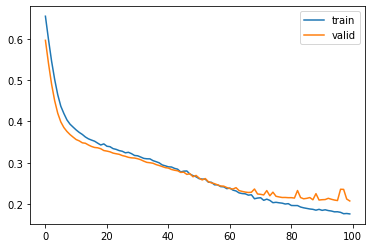

In [34]:
from matplotlib import pyplot
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.legend()
pyplot.show()

In [18]:
from numpy import loadtxt
from keras.models import load_model
# Save model
# lenet.save("NADH_FLIM.h5")
lenet_flim = load_model('NADH_FLIM.h5')

In [19]:
_, acc = lenet_flim.evaluate(testImage, testLabelM, verbose=0)
_, valid_acc = lenet_flim.evaluate(validImage, validLabelM, verbose=0)
_, train_acc = lenet_flim.evaluate(enlargeTrainImage, enlargeTrainLabel, verbose=0)
print('= %.3f' % (acc * 100.0))
print('= %.3f' % (valid_acc * 100.0))
print('= %.3f' % (train_acc * 100.0))

= 94.474
= 93.097
= 95.004


In [27]:
## Define a function to calculate AUC, and confusion matrix
def Evaluate_Prediction_Performance_CNN(testImage,model,testLabel):
    
    # Compute the PR-curve points
    testPredictResult = model.predict(testImage)
    testPredictProb = [x[1] for x in testPredictResult]
    testReal = [np.argmax(i) for i in testLabel]
    testPredict = [np.argmax(i) for i in testPredictResult]
    
    precision, recall, thresholds = metrics.precision_recall_curve(testReal,testPredictProb)
    
    # Compute the roc-curve points
    fpr, tpr, roc_thresholds = metrics.roc_curve(testReal, testPredictProb)
        
    # Compute other metrics
    acc = metrics.accuracy_score(testReal, testPredict)
    auc = metrics.roc_auc_score(testReal, testPredictProb)
    ap = metrics.average_precision_score(testReal, testPredictProb)
    rc = metrics.recall_score(testReal, testPredict)
    print("\t=> acc={:.3f}, ap={:.3f}, auc={:.3f}, rc={:.3f}\n".format(acc, ap, auc, rc))
    
    return(precision,recall,thresholds,fpr,tpr,roc_thresholds,acc,auc,ap,ap)

In [36]:
flimLETPerf = Evaluate_Prediction_Performance_CNN(testImage,lenet_flim,testLabelM)

	=> acc=0.945, ap=0.982, auc=0.987, rc=0.915



#### 3.2 Compare with machine learning

In [30]:
def Calculate_Mean_Endpoint(imageList):
    meanEndpointList = np.empty(len(imageList))
    for i in range(len(imageList)):
        image = imageList[i]
        meanEndpointList[i] = np.mean(image[np.nonzero(image)])
    return meanEndpointList

def Combine_Endpoint_Mean(intImageList, tmImageList,a1ImageList, t1ImageList, t2ImageList,label):
    meanFeatureList = np.empty(len(intImageList), dtype=object)
    meanIntList = Calculate_Mean_Endpoint(intImageList)
    meanTmList = Calculate_Mean_Endpoint(tmImageList)
    meana1List = Calculate_Mean_Endpoint(a1ImageList)
    meanT1List = Calculate_Mean_Endpoint(t1ImageList)
    meanT2List = Calculate_Mean_Endpoint(t2ImageList)
    for i in range(len(intImageList)):
        meanInt = meanIntList[i]
        meanTm = meanTmList[i]
        meana1 = meana1List[i]
        meanT1 = meanT1List[i]
        meanT2 = meanT2List[i]
        featureVector = np.array([meanInt,meanTm,meana1,meanT1,meanT2])
        meanFeatureList[i] = [featureVector,label]
    return meanFeatureList

In [31]:
controlFeatureList = Combine_Endpoint_Mean(controlIntImageList,controlTmImageList,controlA1ImageList,controlT1ImageList,controlT2ImageList,2)
glyFeatureList = Combine_Endpoint_Mean(glyIntImageList,glyTmImageList,glyA1ImageList,glyT1ImageList,glyT2ImageList,0)
cyanideFeatureList = Combine_Endpoint_Mean(cyanideIntImageList,cyanideTmImageList,cyanideA1ImageList,cyanideT1ImageList,cyanideT2ImageList,1)

In [32]:
import math
import random
allFeatureList = np.concatenate((glyFeatureList,cyanideFeatureList), axis=0)

random.shuffle(allFeatureList)
# 60% dataset for training
trainFeatureList = allFeatureList[:math.floor(len(allFeatureList)*0.6)]
# 40% dataset for testing
testFeatureList = allFeatureList[math.floor(len(allFeatureList)*0.6):]

In [33]:
def Get_Label_Feature(featureList):
    label = np.array([])
    feature = np.empty(shape = (len(featureList),5))
    for i in range(len(featureList)):
        label = np.append(label, featureList[i][1])
        feature[i][0] = featureList[i][0][0]
        feature[i][1] = featureList[i][0][1]
        feature[i][2] = featureList[i][0][2]
        feature[i][3] = featureList[i][0][3]
        feature[i][4] = featureList[i][0][4]

    return(feature, label)

In [34]:
from tensorflow.keras.utils import to_categorical

(trainFeature, trainFeatureLabel) = Get_Label_Feature(trainFeatureList)
(testFeature, testFeatureLabel) = Get_Label_Feature(testFeatureList)
(allFeature, allFeatureLabel) = Get_Label_Feature(allFeatureList)

In [35]:
# evaluate random forest algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
# define dataset
model = svm.SVC(probability=True)
# model = RandomForestClassifier()
# model = QuadraticDiscriminantAnalysis()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model,allFeature, allFeatureLabel, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.868 (0.008)


In [47]:
def Evaluate_Prediction_Performance_CML(model,trainFeature,trainFeatureLabel,testFeature,testFeatureLabel):
    model.fit(trainFeature,trainFeatureLabel)
    
    testPredictResult = model.predict_proba(testFeature)
    testPredictProb = [x[1] for x in testPredictResult]
    testPredict = [np.argmax(i) for i in testPredictResult]
    
    # Compute the PR-curve points
    precision, recall, thresholds = metrics.precision_recall_curve(testFeatureLabel,testPredictProb,)
    # Compute the roc-curve points
    fpr, tpr, roc_thresholds = metrics.roc_curve(testFeatureLabel, testPredictProb)
    
    # Compute other metrics
    acc = metrics.accuracy_score(testFeatureLabel, testPredict)
    auc = metrics.roc_auc_score(testFeatureLabel, testPredictProb)
    ap = metrics.average_precision_score(testFeatureLabel, testPredictProb)
    rc = metrics.recall_score(testFeatureLabel, testPredict)
    print("\t=> acc={:.3f}, ap={:.3f}, auc={:.3f}, rc={:.3f}\n".format(acc, ap, auc, rc))
    
    return(precision,recall,thresholds,fpr,tpr,roc_thresholds,acc,auc,ap,ap)

In [49]:
svmPerf = Evaluate_Prediction_Performance_CML(svm.SVC(probability=True),trainFeature,trainFeatureLabel,testFeature,testFeatureLabel)
rftPerf = Evaluate_Prediction_Performance_CML(RandomForestClassifier(),trainFeature,trainFeatureLabel,testFeature,testFeatureLabel)
qdaPerf = Evaluate_Prediction_Performance_CML(QuadraticDiscriminantAnalysis(),trainFeature,trainFeatureLabel,testFeature,testFeatureLabel)

	=> acc=0.854, ap=0.868, auc=0.929, rc=0.807

	=> acc=0.886, ap=0.925, auc=0.950, rc=0.840

	=> acc=0.863, ap=0.887, auc=0.923, rc=0.855



### 4. Analyze the performance

#### Display the wrong images and labels

In [ ]:
wrongNumbers = [i for i in range(len(testPredict)) if testPredict[i] != testReal[i]]
def Get_Wrong_Images(wrongNumbers, testImage, testLabel):
    imageNumber = len(wrongNumbers)
    wrongImage = np.empty([imageNumber,56,56])
    wrongLabel = np.empty([imageNumber,2])
    for i in range(imageNumber):
        wrongImage[i] = testImage[wrongNumbers[i],:,:,1]
        wrongLabel[i] = testLabel[wrongNumbers[i]]
    return wrongImage, wrongLabel

In [ ]:
(wrongImage,wrongLabel) = Get_Wrong_Images(wrongNumbers,testImage,testLabel)

In [ ]:
def Montage_Image(imageList,n_col, image_size=56, margin=2):
    """
    Plot all the images listed in `img_names` in a gird with `n_col` columns.
    Images will be resized to `image_size`*`image_size`.
    This function assumes input images have the same shape.
    
    Args:
        img_names([string]): list of image paths
        n_col(int): number of images in one row
        image_size(int): the length of each image on the montage view
        margin(int): the horizonal and vertical gap between image image
        
    Returns:
        np.array: The montage view of all images listed in `img_names`
    """
    img_list = []
    for image in imageList:
        img_list.append(image)
    stack = np.hstack(img_list)

    # Compute number of rows
    n_row = math.ceil(len(imageList) / n_col)
    image = np.ones((n_row * image_size + (n_row - 1) * margin,
                     n_col * image_size + (n_col - 1) * margin)) * 255

    for i in range(int(stack.shape[1] / image_size)):
        r, c = i // n_col, i % n_col
        image[image_size * r + r * margin : image_size * (r + 1) + r * margin,
              image_size * c + c * margin : image_size * (c + 1) + c * margin
             ] = stack[:, image_size * i : image_size * (i + 1)]
        
    return image

In [ ]:
### Control Montage Image
montageWrongImage = Montage_Image(wrongImage, 8, image_size=56, margin=3)
plt.figure(figsize=(20, round(montageWrongImage.shape[1] / montageWrongImage.shape[0] * 20)))
plt.imshow(montageWrongImage, cmap='viridis',vmax =1)
plt.axis('off')
plt.title('Wrong Prediction Group',fontsize = 20)
plt.colorbar(shrink = 0.3)
plt.show()

### 5. CHOOSE INPUT ENDPOINTS

In [59]:
def Selet_Input_Endpoint(image):
    # NADH Intensity
#     newImage = image[:,:,:,0]
    # NADH tm
#     newImage = image[:,:,:,1]
#     # NADH tm + Intensity
    newImage = image[:,:,:,[0,1]]
    return newImage

In [60]:
newEnlargeTrainImage = Selet_Input_Endpoint(enlargeTrainImage)
newValidImage = Selet_Input_Endpoint(validImage)
newTestImage = Selet_Input_Endpoint(testImage)
print(newEnlargeTrainImage.shape)
print(newValidImage.shape)
print(newTestImage.shape)

(24320, 40, 40, 2)
(507, 40, 40, 2)
(1520, 40, 40, 2)


In [57]:
newEnlargeTrainImage = np.reshape(newEnlargeTrainImage, (24320, 40, 40, 1))
newValidImage = np.reshape(newValidImage, (507, 40, 40, 1))
newTestImage = np.reshape(newTestImage, (1520, 40, 40, 1))
print(newEnlargeTrainImage.shape)
print(newValidImage.shape)
print(newTestImage.shape)

(24320, 40, 40, 1)
(507, 40, 40, 1)
(1520, 40, 40, 1)


#### 5.1 NADH intensity/tm model

In [66]:
def Develop_Model():
    model = Sequential()
    model.add(Conv2D(filters = 64, 
                     kernel_size = (3, 3), 
                     padding="valid",
                     activation='sigmoid', 
                     input_shape=(40, 40, 1)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides = 3))
    model.add(BatchNormalization())
    
    
    model.add(Conv2D(filters = 64,
                     kernel_size=(3,3),
                     padding="valid",
                     activation="sigmoid"))    
    model.add(MaxPooling2D(pool_size = 3, strides = 3))
    model.add(BatchNormalization())

#    map to 1x1 (flatten layer)
    model.add(Flatten())
    
    model.add(Dense(120, activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(80, activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation="softmax", name="Output"))

    
    # compile model
    opt = SGD(lr=0.00001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# NADH Intensity
lenet_Int = Develop_Model()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience = 50)
history = lenet_Int.fit(newEnlargeTrainImage, enlargeTrainLabel, epochs = 100, batch_size = 16,validation_data=(newValidImage, validLabelM), verbose = 1,callbacks=[es])

In [ ]:
# NADH tm
lenet_tm = Develop_Model()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience = 50)
history = lenet_tm.fit(newEnlargeTrainImage, enlargeTrainLabel, epochs = 100, batch_size = 16,validation_data=(newValidImage, validLabelM), verbose = 1,callbacks=[es])

#### 5.2 NADH intensity + tm model

In [77]:
def Develop_Model():
    model = Sequential()
    model.add(Conv2D(filters = 64, 
                     kernel_size = (3, 3), 
                     padding="valid",
                     activation='sigmoid', 
                     input_shape=(40, 40, 2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides = 3))
    model.add(BatchNormalization())
    
    
    model.add(Conv2D(filters = 64,
                     kernel_size=(3,3),
                     padding="valid",
                     activation="sigmoid"))    
    model.add(MaxPooling2D(pool_size = 3, strides = 3))
    model.add(BatchNormalization())

#    map to 1x1 (flatten layer)
    model.add(Flatten())
    
    model.add(Dense(120, activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(80, activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation="softmax", name="Output"))

    
    # compile model
    opt = SGD(lr=0.00001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [79]:
# NADH Intensity + tm
lenet_Int_tm = Develop_Model()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience = 100)
history = lenet_Int_tm.fit(newEnlargeTrainImage, enlargeTrainLabel, epochs = 150, batch_size = 16,validation_data=(newValidImage, validLabelM), verbose = 1,callbacks=[es])

Epoch 1/150
1520/1520 [==============================] - 7s 4ms/step - loss: 0.7609 - accuracy: 0.5285 - val_loss: 0.6261 - val_accuracy: 0.6805
Epoch 2/150
1520/1520 [==============================] - 7s 4ms/step - loss: 0.6429 - accuracy: 0.6630 - val_loss: 0.5723 - val_accuracy: 0.7258
Epoch 3/150
1520/1520 [==============================] - 7s 4ms/step - loss: 0.5948 - accuracy: 0.7065 - val_loss: 0.5418 - val_accuracy: 0.7298
Epoch 4/150
1520/1520 [==============================] - 6s 4ms/step - loss: 0.5698 - accuracy: 0.7233 - val_loss: 0.5209 - val_accuracy: 0.7475
Epoch 5/150
1520/1520 [==============================] - 6s 4ms/step - loss: 0.5442 - accuracy: 0.7468 - val_loss: 0.5035 - val_accuracy: 0.7633
Epoch 6/150
1520/1520 [==============================] - 6s 4ms/step - loss: 0.5307 - accuracy: 0.7509 - val_loss: 0.4883 - val_accuracy: 0.7751
Epoch 7/150
1520/1520 [==============================] - 6s 4ms/step - loss: 0.5215 - accuracy: 0.7648 - val_loss: 0.4772 - val_ac

1520/1520 [==============================] - 6s 4ms/step - loss: 0.2633 - accuracy: 0.8906 - val_loss: 0.2790 - val_accuracy: 0.8836
Epoch 114/150
1520/1520 [==============================] - 6s 4ms/step - loss: 0.2565 - accuracy: 0.8996 - val_loss: 0.2832 - val_accuracy: 0.8757
Epoch 115/150
1520/1520 [==============================] - 6s 4ms/step - loss: 0.2569 - accuracy: 0.8998 - val_loss: 0.2780 - val_accuracy: 0.8817
Epoch 116/150
1520/1520 [==============================] - 6s 4ms/step - loss: 0.2594 - accuracy: 0.8954 - val_loss: 0.2794 - val_accuracy: 0.8876
Epoch 117/150
1520/1520 [==============================] - 6s 4ms/step - loss: 0.2624 - accuracy: 0.8966 - val_loss: 0.2833 - val_accuracy: 0.8895
Epoch 118/150
1520/1520 [==============================] - 6s 4ms/step - loss: 0.2606 - accuracy: 0.8939 - val_loss: 0.2923 - val_accuracy: 0.8836
Epoch 119/150
1520/1520 [==============================] - 6s 4ms/step - loss: 0.2605 - accuracy: 0.8936 - val_loss: 0.2901 - val_ac

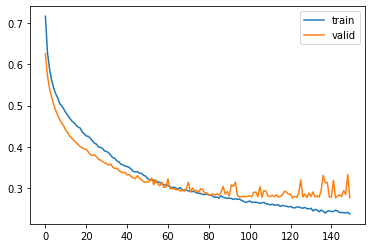

In [80]:
from matplotlib import pyplot
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.legend()
pyplot.show()

In [88]:
testPredictResult = lenet_Int_tm.predict(newTestImage)
testPredictProb = [x[1] for x in testPredictResult]
testReal = [np.argmax(i) for i in testLabelM]
testPredict = [np.argmax(i) for i in testPredictResult]       
precision, recall, thresholds = metrics.precision_recall_curve(testReal,testPredictProb)

# Compute the roc-curve points
fpr, tpr, roc_thresholds = metrics.roc_curve(testReal, testPredictProb)
                
# Compute other metrics
acc = metrics.accuracy_score(testReal, testPredict)
auc = metrics.roc_auc_score(testReal, testPredictProb)
ap = metrics.average_precision_score(testReal, testPredictProb)
rc = metrics.recall_score(testReal, testPredict)

In [72]:
def Show_Prediction_Accuracy(model):
    _, acc = model.evaluate(newTestImage, testLabelM, verbose=0)
    _, valid_acc = model.evaluate(newValidImage, validLabelM, verbose=0)
    _, train_acc = model.evaluate(newEnlargeTrainImage, enlargeTrainLabel, verbose=0)
    print('Test Accuracy = %.3f' % (acc * 100.0))
    print('Valid Accuracy = %.3f' % (valid_acc * 100.0))
    print('Train Accuracy = %.3f' % (train_acc * 100.0))
    print('AUC = %.3f' % (auc * 100.0))

In [83]:
Show_Prediction_Accuracy(lenet_Int_tm)

Test Accuracy = 89.868
Valid Accuracy = 88.166
Train Accuracy = 92.315
AUC = 96.161


In [85]:
from numpy import loadtxt
from keras.models import load_model
# Save model
# lenet_Int.save("NADH_Int.h5")
# lenet_tm.save("NADH_tm.h5")
# lenet_Int_tm.save("NADH_Int_tm.h5")

### 6. Result Summary

#### 6.1 Compare the AUC curve

In [54]:
##### NADH intensity model performance ####
lenet_Int = load_model('NADH_Int.h5')
intLETPerf = Evaluate_Prediction_Performance_CNN(newTestImage,lenet_Int,testLabelM)

	=> acc=0.757, ap=0.765, auc=0.807, rc=0.600



In [58]:
##### NADH tm model performance ####
lenet_tm = load_model('NADH_tm.h5')
tmLETPerf = Evaluate_Prediction_Performance_CNN(newTestImage,lenet_tm,testLabelM)

	=> acc=0.851, ap=0.874, auc=0.926, rc=0.813



In [62]:
lenet_Int_tm = load_model('NADH_Int_tm.h5')
int_tmLETPerf = Evaluate_Prediction_Performance_CNN(newTestImage,lenet_Int_tm,testLabelM)

	=> acc=0.899, ap=0.952, auc=0.962, rc=0.845



In [63]:
# define a function to get the fprs, and tprs
def Get_Fprs_Tprs(modelPerformance):
    fprs = modelPerformance[3]
    tprs = modelPerformance[4]
    return(fprs,tprs)

# define a function to get the recalls, precisions
def Get_Recalls_Precisions(modelPerformance):
    recalls = modelPerformance[0]
    precisions = modelPerformance[1]
    return(recalls,precisions)

In [78]:
# NADH FLIM
(flimLetFprs,flimLetTprs) = Get_Fprs_Tprs(flimLETPerf)
(flimLetRecalls,flimLetPrecisions) = Get_Recalls_Precisions(flimLETPerf)
# NADH Int
(intLetFprs,intLetTprs) = Get_Fprs_Tprs(intLETPerf)
(intLetRecalls,intLetPrecisions) = Get_Recalls_Precisions(intLETPerf)
# NADH tm
(tmLetFprs,tmLetTprs) = Get_Fprs_Tprs(tmLETPerf)
(tmLetRecalls,tmLetPrecisions) = Get_Recalls_Precisions(tmLETPerf)
# NADH tm + Int
(int_tmLetFprs,int_tmLetTprs) = Get_Fprs_Tprs(int_tmLETPerf)
(int_tmLetRecalls,int_tmLetPrecisions) = Get_Recalls_Precisions(int_tmLETPerf)

# SVM
(svmFprs,svmTprs) = Get_Fprs_Tprs(svmPerf)
(svmRecalls,svmPrecisions) = Get_Recalls_Precisions(svmPerf)
# RFT
(rftFprs,rftTprs) = Get_Fprs_Tprs(rftPerf)
(rftRecalls,rftPrecisions) = Get_Recalls_Precisions(rftPerf)
# QDA
(qdaFprs,qdaTprs) = Get_Fprs_Tprs(qdaPerf)
(qdaRecalls,qdaPrecisions) = Get_Recalls_Precisions(qdaPerf)

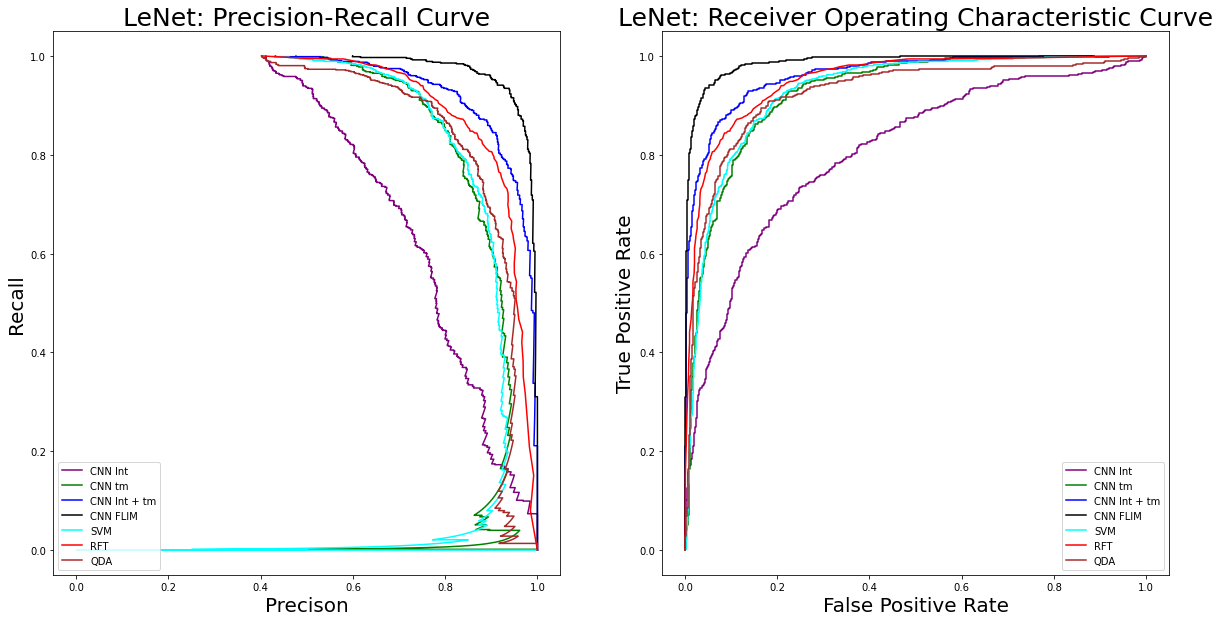

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].plot(intLetRecalls,intLetPrecisions, linestyle = 'solid',color = 'purple',label='CNN Int')
ax[0].plot(tmLetRecalls,tmLetPrecisions, linestyle = 'solid',color = 'green',label='CNN tm')
ax[0].plot(int_tmLetRecalls,int_tmLetPrecisions, linestyle = 'solid',color = 'blue',label='CNN Int + tm')
ax[0].plot(flimLetRecalls,flimLetPrecisions, linestyle = 'solid',color = 'black',label='CNN FLIM')

ax[0].plot(svmRecalls,svmPrecisions, linestyle = 'solid',color = 'cyan',label='SVM')
ax[0].plot(rftRecalls,rftPrecisions, linestyle = 'solid',color = 'red',label='RFT')
ax[0].plot(qdaRecalls,qdaPrecisions, linestyle = 'solid',color = 'brown',label='QDA')

ax[0].set_title("LeNet: Precision-Recall Curve",fontsize=25)
ax[0].set_xlabel("Precison",fontsize=20)
ax[0].set_ylabel("Recall",fontsize=20)
ax[0].legend(loc=3)



ax[1].plot(intLetFprs,intLetTprs, linestyle = 'solid',color = 'purple',label='CNN Int')
ax[1].plot(tmLetFprs,tmLetTprs, linestyle = 'solid',color = 'green',label='CNN tm')
ax[1].plot(int_tmLetFprs,int_tmLetTprs, linestyle = 'solid',color = 'blue',label='CNN Int + tm')
ax[1].plot(flimLetFprs,flimLetTprs, linestyle = 'solid',color = 'black',label='CNN FLIM')

ax[1].plot(svmFprs,svmTprs, linestyle = 'solid',color = 'cyan',label='SVM')
ax[1].plot(rftFprs,rftTprs, linestyle = 'solid',color = 'red',label='RFT')
ax[1].plot(qdaFprs,qdaTprs, linestyle = 'solid',color = 'brown',label='QDA')

ax[1].set_title("LeNet: Receiver Operating Characteristic Curve",fontsize=25)
ax[1].set_xlabel("False Positive Rate",fontsize=20)
ax[1].set_ylabel("True Positive Rate",fontsize=20)

ax[1].legend(loc=4)
plt.show()

#### 6.2 Current Summary

### TRANSFER LEARNING 

In [109]:
### Transfer Learning with VGG 16, Intensity, tm, a1
tEnlargeTrainImage = enlargeTrainImage[:,:,:,[0,1,4]]
tValidImage = validImage[:,:,:,[0,1,4]]
tTestImage = testImage[:,:,:,[0,1,4]]
print(tEnlargeTrainImage.shape)
print(tValidImage.shape)
print(tTestImage.shape)

(24320, 40, 40, 3)
(507, 40, 40, 3)
(1520, 40, 40, 3)


In [81]:
# example of tending the vgg16 model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

# load model without classifier layers
model = VGG16(include_top=False, input_shape=(40, 40, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(2, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40, 40, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 40, 40, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 40, 40, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 20, 20, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 20, 20, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 20, 20, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 10, 10, 128)       0   

In [82]:
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(enlargeTrainImage, enlargeTrainLabel, epochs = 10, batch_size = 8,validation_data=(validImage, validLabelM), verbose=1)

Epoch 1/10
3040/3040 [==============================] - 65s 21ms/step - loss: 0.3666 - accuracy: 0.8402 - val_loss: 0.2685 - val_accuracy: 0.8856
Epoch 2/10
3040/3040 [==============================] - 66s 22ms/step - loss: 0.2152 - accuracy: 0.9143 - val_loss: 0.2336 - val_accuracy: 0.9172
Epoch 3/10
3040/3040 [==============================] - 67s 22ms/step - loss: 0.1654 - accuracy: 0.9373 - val_loss: 0.2393 - val_accuracy: 0.8994
Epoch 4/10
3040/3040 [==============================] - 68s 22ms/step - loss: 0.1422 - accuracy: 0.9445 - val_loss: 0.2270 - val_accuracy: 0.9152
Epoch 5/10
3040/3040 [==============================] - 68s 22ms/step - loss: 0.1199 - accuracy: 0.9542 - val_loss: 0.2200 - val_accuracy: 0.9191
Epoch 6/10
3040/3040 [==============================] - 68s 22ms/step - loss: 0.1095 - accuracy: 0.9572 - val_loss: 0.2312 - val_accuracy: 0.9132
Epoch 7/10
3040/3040 [==============================] - 68s 22ms/step - loss: 0.0936 - accuracy: 0.9637 - val_loss: 0.2870 -

In [83]:
# evaluate model
_, acc = model.evaluate(testImage, testLabelM, verbose=0)
print('= %.3f' % (acc * 100.0))
_, valid_acc = model.evaluate(validImage, validLabelM, verbose=0)
print('= %.3f' % (valid_acc * 100.0))

= 93.026
= 91.124
